# Bitcoin Price Forecast for Future Periods. LSTM Model

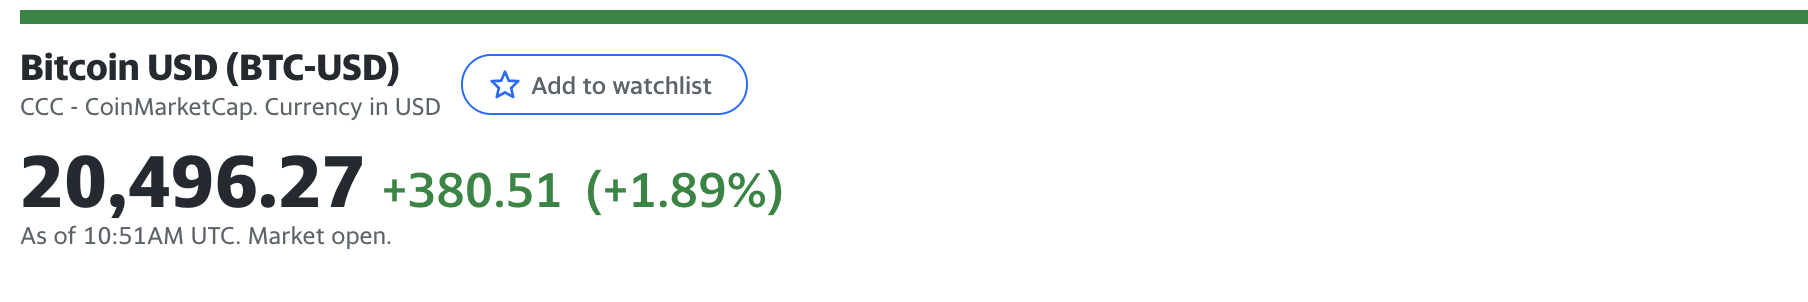

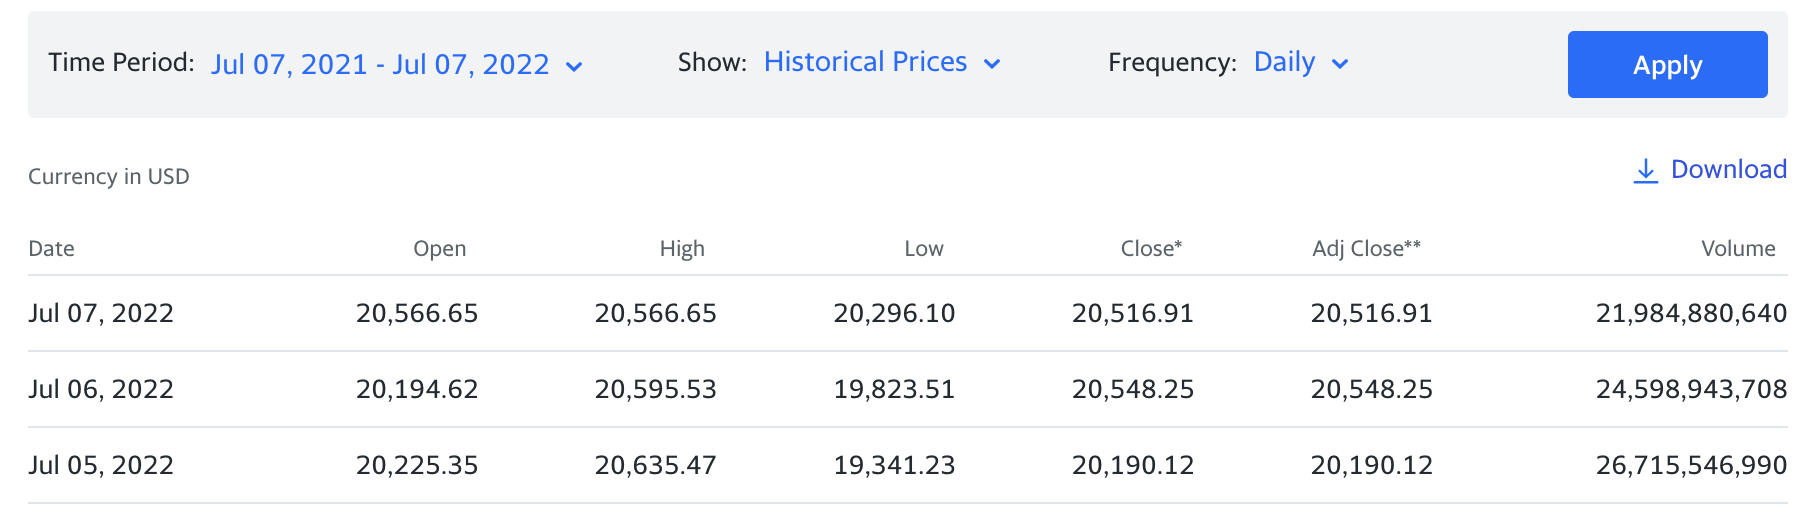

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Training-of-the-basic-LSTM-model" data-toc-modified-id="Training-of-the-basic-LSTM-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training of the basic LSTM model</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prediction</a></span></li><li><span><a href="#Prediction-for-next-week" data-toc-modified-id="Prediction-for-next-week-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction for next week</a></span><ul class="toc-item"><li><span><a href="#At-the-moment,-the-model-looks-well-trained-but-predicts-unexpected-results-in-the-future." data-toc-modified-id="At-the-moment,-the-model-looks-well-trained-but-predicts-unexpected-results-in-the-future.-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>At the moment, the model looks well trained but predicts unexpected results in the future.</a></span></li></ul></li></ul></div>

## Preparation

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
import plotly
import plotly.graph_objs as go

In [2]:
df = pd.read_csv('BTC-USD.csv', sep=',', parse_dates=['Date']).round(2)

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.86,468.17,452.42,457.33,457.33,21056800
1,2014-09-18,456.86,456.86,413.10,424.44,424.44,34483200
2,2014-09-19,424.10,427.83,384.53,394.80,394.80,37919700
3,2014-09-20,394.67,423.30,389.88,408.90,408.90,36863600
4,2014-09-21,408.08,412.43,393.18,398.82,398.82,26580100


In [15]:
 df.drop(df.tail(1).index,inplace=True)

In [16]:
print(df['Date'].min())
print(df['Date'].max())

2014-09-17 00:00:00
2022-07-06 00:00:00


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 0 to 2849
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2850 non-null   datetime64[ns]
 1   Open       2850 non-null   float64       
 2   High       2850 non-null   float64       
 3   Low        2850 non-null   float64       
 4   Close      2850 non-null   float64       
 5   Adj Close  2850 non-null   float64       
 6   Volume     2850 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 178.1 KB


In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(
           x=df['Date'], 
           y=df['Close']))

fig.update_layout(
    title_text='Bitcoin price by days since the start of trading',
    xaxis_title_text='Price', 
    yaxis_title_text='Day', 
)
fig.show()

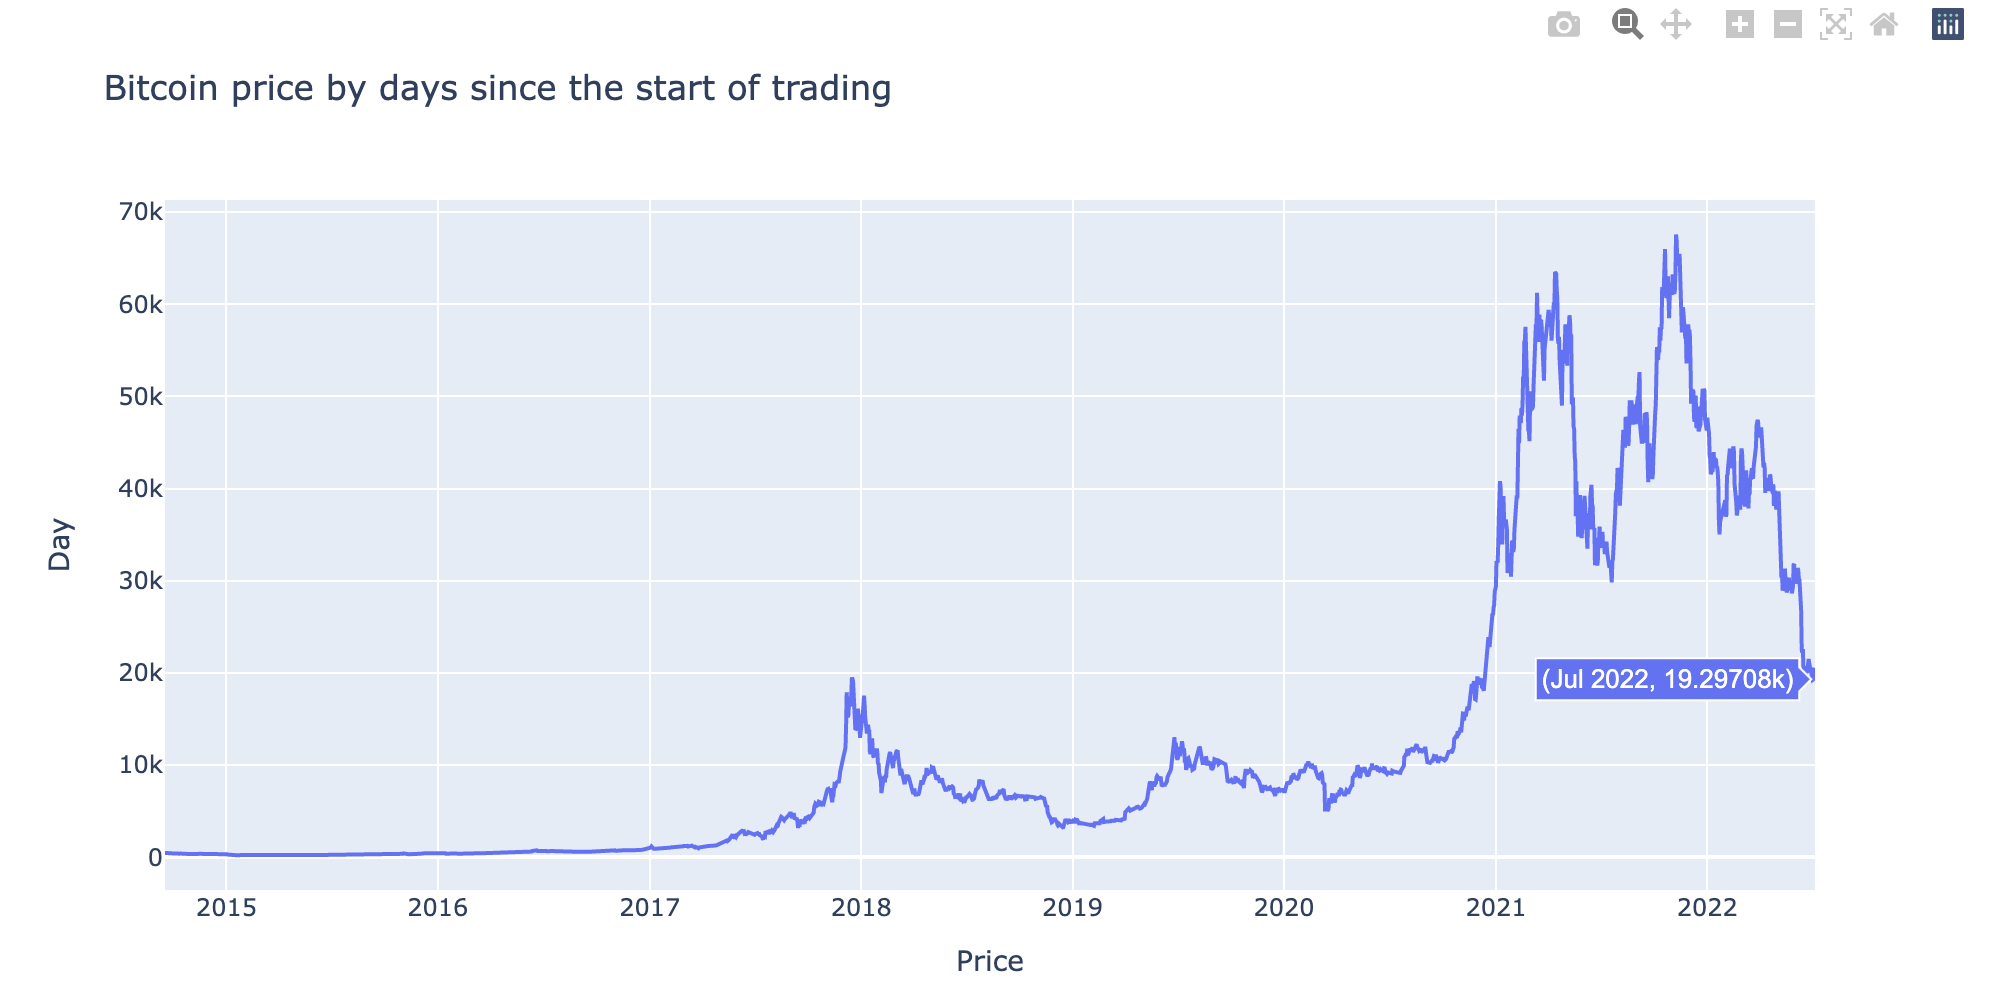

 ## Data Preprocessing

In [19]:
num_shape = 2800

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [20]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

Now we take one row and cut it with a window of 60 elements.

In [21]:
X_train = []
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

## Training of the basic LSTM model

In [22]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [24]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32);

Epoch 1/100
86/86 [==============================] - 35s 339ms/step - loss: 0.0033
Epoch 2/100
86/86 [==============================] - 30s 346ms/step - loss: 0.0020
Epoch 3/100
86/86 [==============================] - 29s 334ms/step - loss: 0.0022
Epoch 4/100
86/86 [==============================] - 28s 328ms/step - loss: 0.0017
Epoch 5/100
86/86 [==============================] - 29s 343ms/step - loss: 0.0017
Epoch 6/100
86/86 [==============================] - 36s 419ms/step - loss: 0.0016
Epoch 7/100
86/86 [==============================] - 29s 332ms/step - loss: 0.0020
Epoch 8/100
86/86 [==============================] - 26s 306ms/step - loss: 0.0013
Epoch 9/100
86/86 [==============================] - 28s 327ms/step - loss: 0.0015
Epoch 10/100
86/86 [==============================] - 28s 330ms/step - loss: 0.0013
Epoch 11/100
86/86 [==============================] - 32s 370ms/step - loss: 0.0014
Epoch 12/100
86/86 [==============================] - 38s 446ms/step - loss: 0.0013
E

## Prediction

In [91]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [92]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

In [93]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 1212357.5753180946
MAE: 783.6285703125
RMSE: 1101.0711036613823


In [94]:
prediction = pd.DataFrame(predict,columns =['prise'])

In [110]:
fig = go.Figure()
fig.add_trace(go.Scatter(
           x=df['Date'].values[2700:], 
           y=df['Close'].values[2700:],
           name="Real Price"))

fig.add_trace(go.Scatter(
           x=df['Date'].values[-predict.shape[0]:], 
           y=prediction['prise'],
           name="Predicted Price"))

fig.update_layout(
    title_text='Bitcoin price. The result of the modeling.',
    xaxis_title_text='Price', 
    yaxis_title_text='Day', 
)
fig.show()

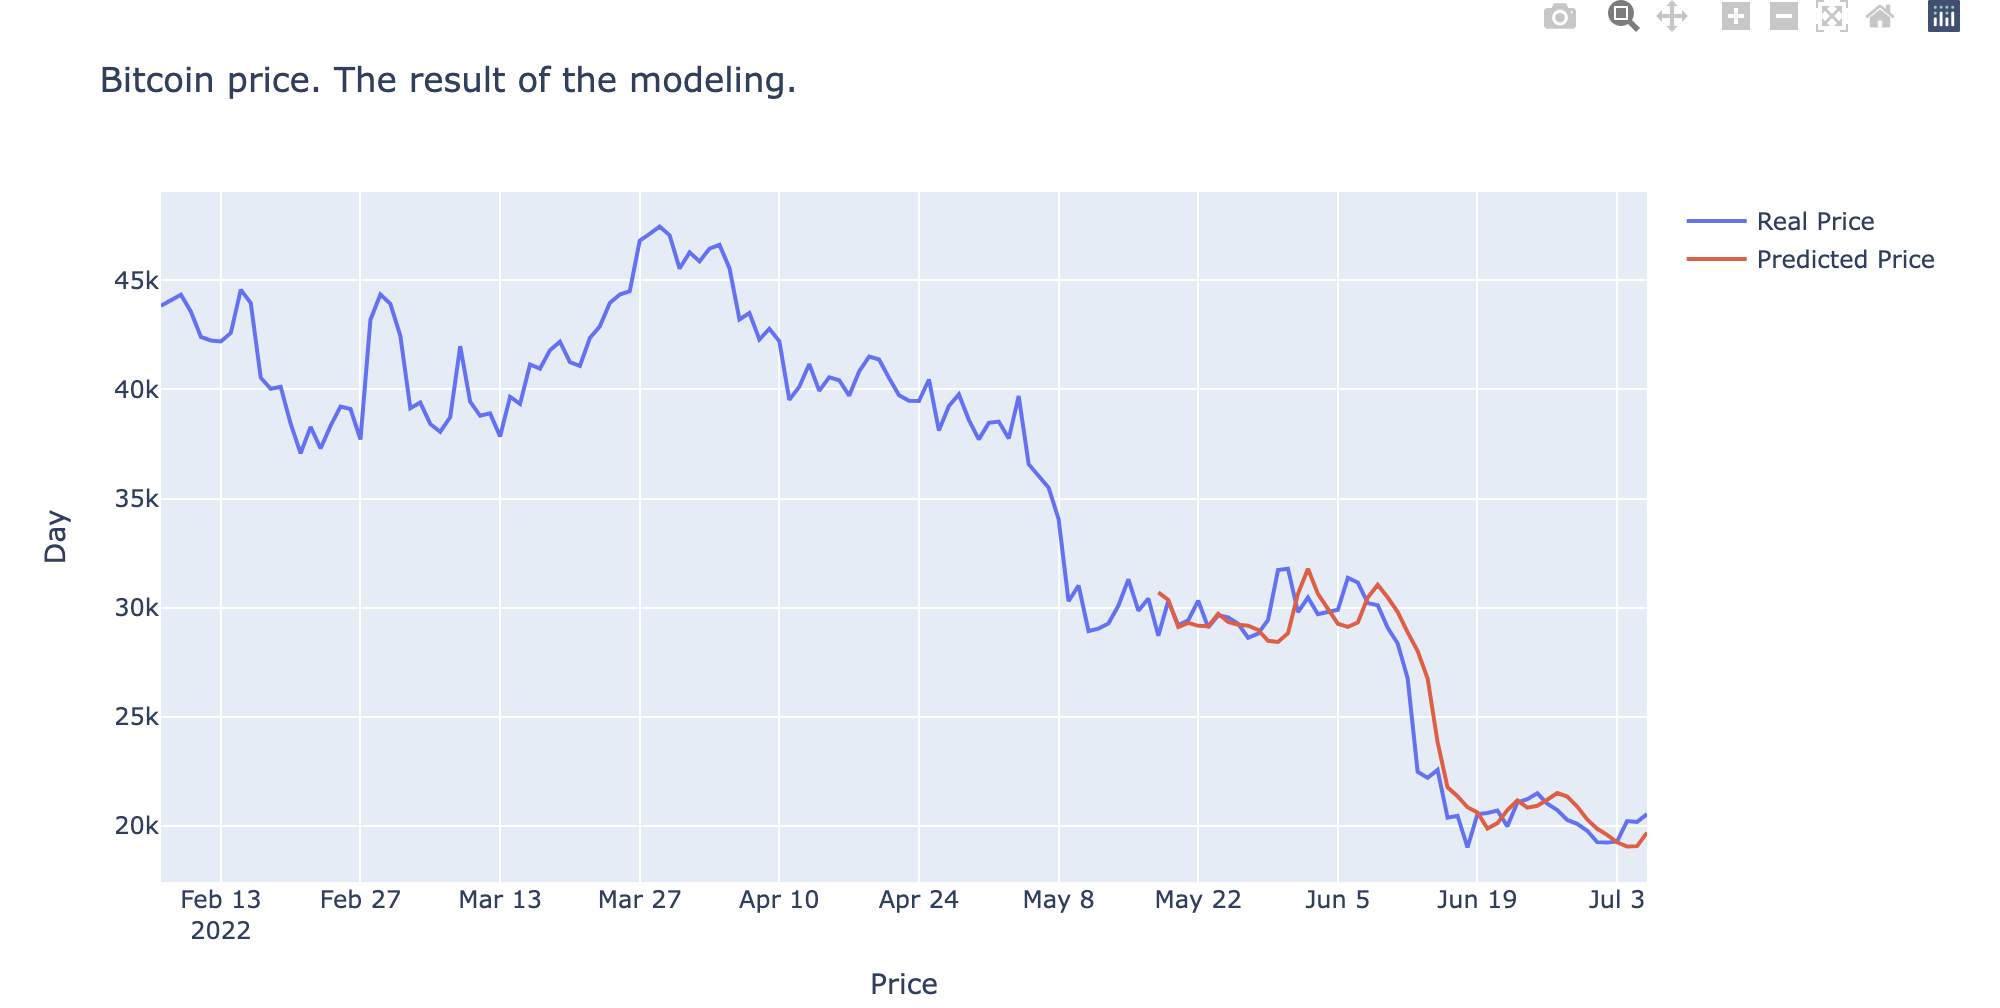

##  Prediction for next week

In [101]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(7):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []
    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [102]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [103]:
df_date = df[['Date']]

for h in range(7):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

In [106]:
p_full_new = pd.DataFrame(prediction_full_new ,columns =['prise'])

In [109]:
fig = go.Figure()
fig.add_trace(go.Scatter(
           x=df['Date'].values[2700:], 
           y=df['Close'].values[2700:],
           name="Real Price"))

fig.add_trace(go.Scatter(
           x=df_date['Date'].values[-prediction_full_new.shape[0]:], 
           y=p_full_new['prise'],
           name="Predicted Price"))

fig.update_layout(
    title_text='Bitcoin price Prediction for next week',
    xaxis_title_text='Price', 
    yaxis_title_text='Day', 
)
fig.show()

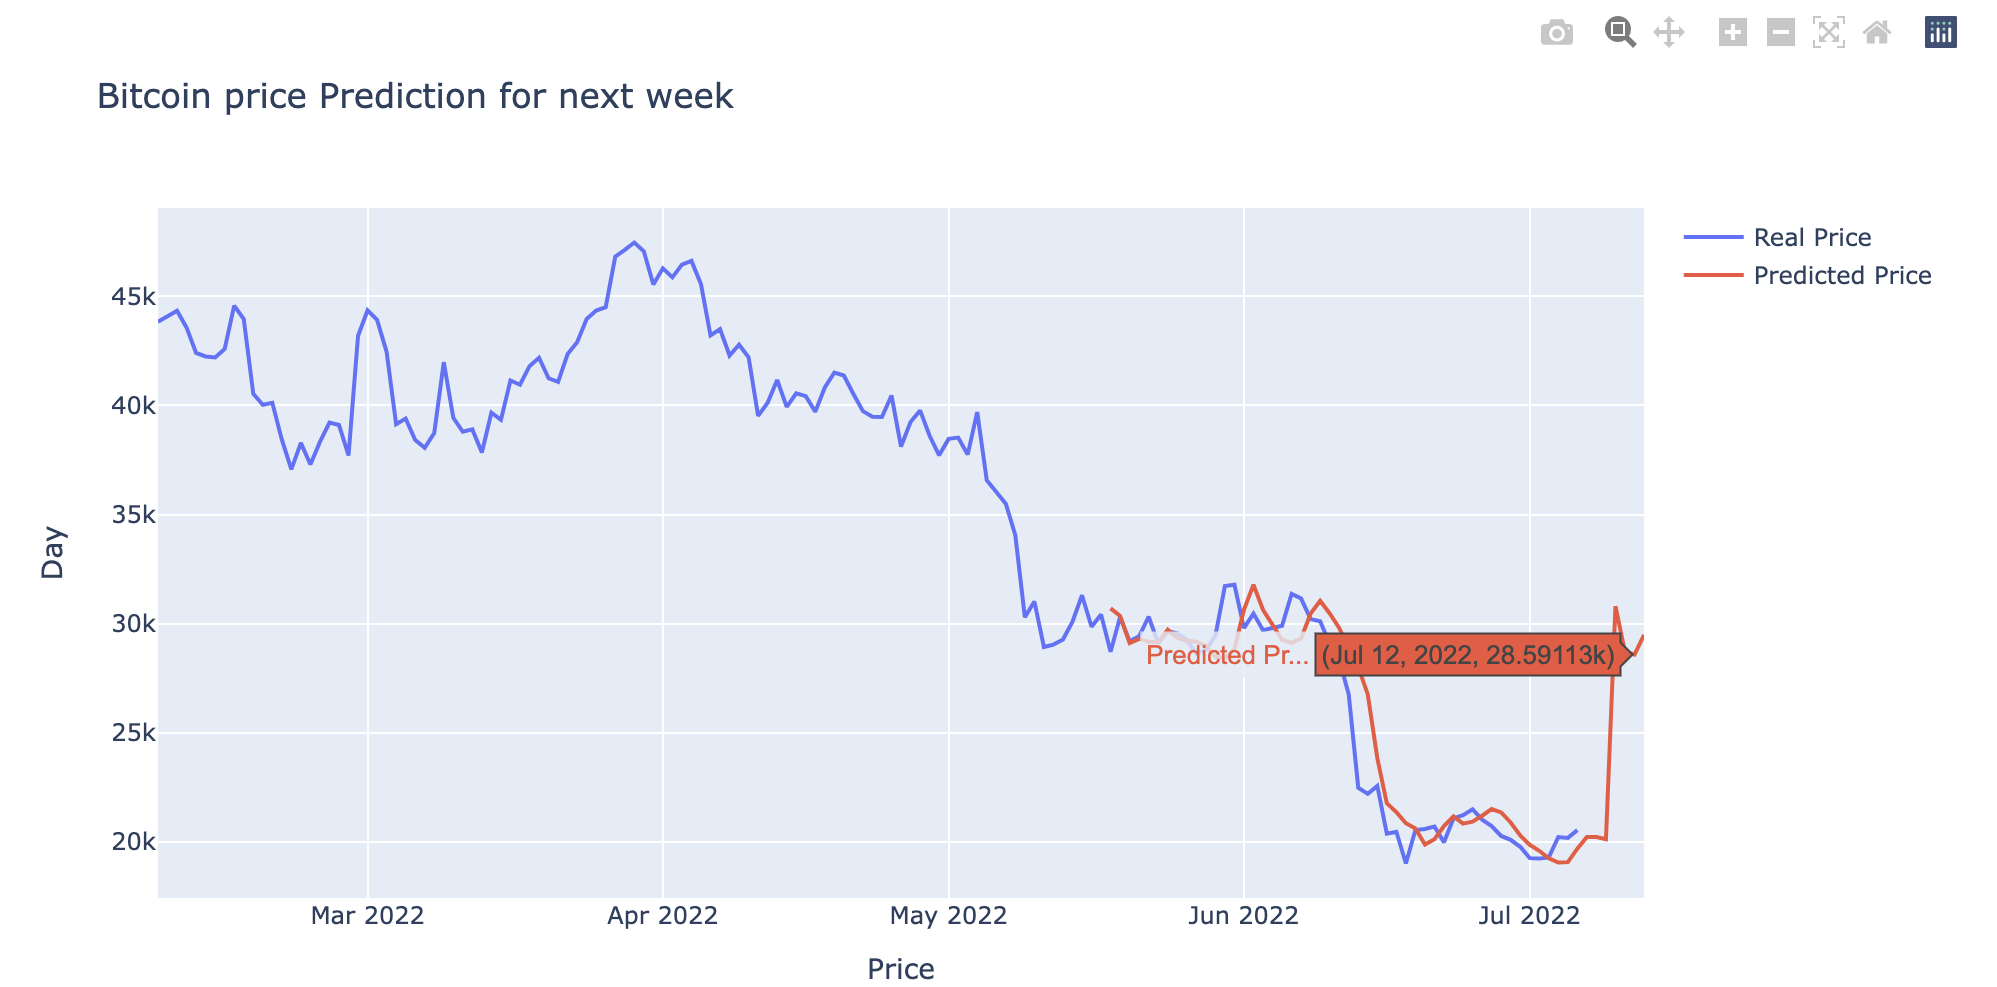

### At the moment, the model looks well trained but predicts unexpected results in the future.